# Error mitigation techniques comparison (benchmarking)

In [2]:
import sys
sys.path.append("..") # This is for the imports from adjacent folders to work
import os  
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

import os  
current_folder = os.getcwd()
figures_folder = os.path.join(current_folder, '..', 'figures')
figures_folder = os.path.abspath(figures_folder)

data_folder = os.path.join(current_folder, '..', 'data')
data_folder = os.path.abspath(data_folder)

from utils.generate_complementary_colors import generate_complementary_colors
from utils.get_circuit_properties import get_circuit_properties
from main_functions.ME_solver import solve_master_equation
from qiskit_ibm_runtime.fake_provider import FakeMarrakesh, FakeTorino, FakeSherbrooke, FakeFez
from qiskit_aer import AerSimulator
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerOptions, SamplerV2, Batch

from utils.isa_zne import extrapolate_to_zero_noise
from utils.isa_cdr import transform_isa_qc, generate_isa_clifford_circuits, get_populations, get_training_data, train_model, correct_observable
from utils.isa_pt import pauli_twirling

After all the benchmarks, the five techniques that should be worth comparing due to their outstanding performance from the rest are: Regular CDR, Inversely-biased CDR, ZNE (random partial gate folding) with linear extrapolation, ZNE (random gate folding) with regular Richardson extrapolation, ZNE (random gate folding) with constrained Richardson extrapolation (either l1 or l2-norm minimizations). Later on, ZNE (random gate folding) with neural networks should be considered too.

STEP 1: Load data 

In [9]:
##### ZERO-NOISE EXTRAPOLATION #####
file_path = os.path.join(data_folder, f'isa_zne_10_emitters_two_trotter_other_init_state.txt')
t = np.loadtxt(file_path, usecols = 0, skiprows = 1)
noiseless_data_error = np.loadtxt(file_path, usecols = -1, skiprows = 1)
noiseless_data = np.loadtxt(file_path, usecols = -2, skiprows = 1)
raw_data_error = np.loadtxt(file_path, usecols = -3, skiprows = 1)
raw_data = np.loadtxt(file_path, usecols = -4, skiprows = 1)
# t = np.loadtxt(file_path, usecols = 0, skiprows = 1)
# noiseless_data = np.loadtxt(file_path, usecols = -2, skiprows = 1)
# raw_data = np.loadtxt(file_path, usecols = -3, skiprows = 1)

lambdas = [1.3, 1.6, 2, 2.3]
noise_amplified_data = {}
error_data = {}
for i in range(len(lambdas)):
    noise_amplified_data[f'lambda={lambdas[i]}'] = np.loadtxt(file_path, usecols = 2*i+1, skiprows = 1)
    error_data[f'lambda={lambdas[i]}'] = np.loadtxt(file_path, usecols = 2*i+2, skiprows = 1)

##### CLIFFORD DATA REGRESSION #####
file_path = os.path.join(data_folder, f'2_IDENTICAL_emitters_cdr_different_methods_FakeMarrakesh_predicted_data.npz')
data = np.load(file_path, allow_pickle = True)
results = {k: data[k].item() for k in data}
cdr_results = results['arr_0']

file_path = os.path.join(data_folder, f'2_IDENTICAL_emitters_cdr_different_methods_FakeMarrakesh_prediction_error.npz')
data = np.load(file_path, allow_pickle = True)
results = {k: data[k].item() for k in data}
cdr_prediction_error = results['arr_0']

file_path = os.path.join(data_folder, f'isa_cdr_10_emitters_two_trotter_other_init_state.txt')
predicted_data = np.loadtxt(file_path, usecols = 3, skiprows = 1)

STEP 2: Perform ZNE

In [10]:
zne_results = { 'extrapolated_evs' : { 'linear' : [], 'richardson' : { 'none' : [], 'l1' : [], 'l2' : [] } }, 'extrapolation_errors' : { 'linear' : [], 'richardson' : { 'none' : [], 'l1' : [], 'l2' : [] } } }

for typ in zne_results['extrapolated_evs'].keys():
    if typ == 'richardson':
        for w_min in zne_results['extrapolated_evs'][typ].keys():
            for idx, inst in enumerate(t):
                fit_values = [ noise_amplified_data[l][idx] for l in noise_amplified_data.keys() ]    
                error_values = [ error_data[l][idx] for l in noise_amplified_data.keys() ]    
                extrapolated_data, extrapolation_error = extrapolate_to_zero_noise(lambdas, fit_values, typ, 1, w_min, True, error_values)
                zne_results['extrapolated_evs'][typ][w_min].append(extrapolated_data)
                zne_results['extrapolation_errors'][typ][w_min].append(extrapolation_error)

    else:
        for idx, inst in enumerate(t):
            fit_values = [ noise_amplified_data[l][idx] for l in noise_amplified_data.keys() ]    
            error_values = [ error_data[l][idx] for l in noise_amplified_data.keys() ]    
            extrapolated_data, extrapolation_error = extrapolate_to_zero_noise(lambdas, fit_values, typ, 1, 'none', True, error_values)
            zne_results['extrapolated_evs'][typ].append(extrapolated_data)
            zne_results['extrapolation_errors'][typ].append(extrapolation_error)

(computing eff gamma for plot qubit)

In [5]:
omega_m = 1.2
omega_c = 1.1
gamma = 0.8*10**(-6)
kappa = 0.2
g = 0.03

delta = omega_m - omega_c
mean_delta = 0.5*(omega_m + omega_m) - omega_c
gamma_eff = gamma + (kappa*(g**2))/((0.5*kappa)**2 + delta**2)

STEP 3: Plot

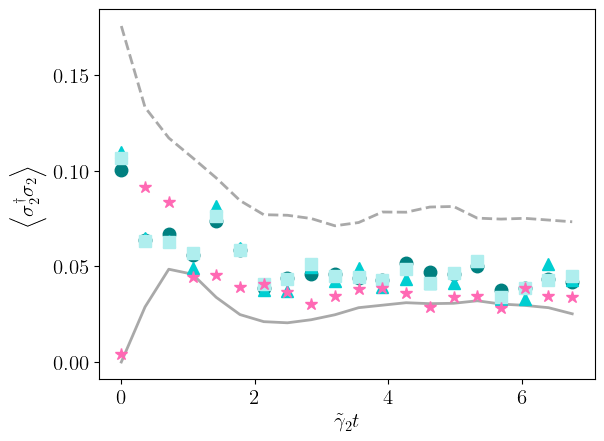

In [ ]:
plt.rcParams.update({'font.size': 15})

# labels_ZNE = { 'linear' : 'ZNE (linear)', 
#            'richardson' : { 'none' : 'ZNE (First-order Richardson)', 
#                              'l1' : 'ZNE (First-order Richardson with l1-norm minimization)',
#                              'l2' : 'ZNE (First-order Richardson with l2-norm minimization)'} }

plot_settings_ZNE = { 'linear' : ['teal', 'none', 'o', 'ZNE (linear)'], 
           'richardson' : { 'none' : ['darkturquoise', 'none', '^', 'ZNE (FOR)'], 
                             'l1' : ['paleturquoise', 'none', 's', 'ZNE (CFOR-l1)']} }

# plot_settings_CDR = { 'inverse' : ['hotpink', 'none', '*', 'CDR (inverse)'],
#                'gaussian' : ['pink', 'none', 'P', 'CDR (Gaussian)'],
#                'uniform' : ['mediumvioletred', 'none', 'x', 'CDR (no bias)']}

plot_settings_CDR = { 'inverse' : ['hotpink', 'none', '*', 'CDR (inverse)'] }

# colors = generate_complementary_colors(7, 'default', 'turquoise')

plt.plot(gamma_eff*t, noiseless_data, color = 'darkgrey', linestyle = 'solid', linewidth = 2, label = 'Noiseless')
plt.plot(gamma_eff*t, raw_data, color = 'darkgrey', linestyle = 'dashed', linewidth = 2, label = 'Raw results (no amplification)')

# [start:end:step]
start = 0
end = -6
step = 6
for typ in zne_results['extrapolated_evs'].keys():
    if typ == 'richardson':
        for w_min in plot_settings_ZNE[typ].keys():
            plt.plot(gamma_eff*t,  zne_results['extrapolated_evs'][typ][w_min], color = plot_settings_ZNE[typ][w_min][0], linestyle = plot_settings_ZNE[typ][w_min][1], marker = plot_settings_ZNE[typ][w_min][2], markersize = 9, label = plot_settings_ZNE[typ][w_min][3])
            # upper_bound = np.array(zne_results['extrapolated_evs'][typ][w_min]) + np.array(zne_results['extrapolation_errors'][typ][w_min])
            # lower_bound = np.array(zne_results['extrapolated_evs'][typ][w_min]) - np.array(zne_results['extrapolation_errors'][typ][w_min])
            #plt.fill_between(t, lower_bound, upper_bound, color=colors[counter], alpha=0.2)
            
            start += 1
            end += 1
    else:
        plt.plot(gamma_eff*t,  zne_results['extrapolated_evs'][typ], color = plot_settings_ZNE[typ][0], linestyle = plot_settings_ZNE[typ][1], marker = plot_settings_ZNE[typ][2], markersize = 9, label = plot_settings_ZNE[typ][3])
        # upper_bound = np.array(zne_results['extrapolated_evs'][typ]) + np.array(zne_results['extrapolation_errors'][typ])
        # lower_bound = np.array(zne_results['extrapolated_evs'][typ]) - np.array(zne_results['extrapolation_errors'][typ])
        #plt.fill_between(t, lower_bound, upper_bound, color=colors[counter], alpha=0.2)

        start += 1
        end += 1
      
#for typ in cdr_results.keys():
for typ in plot_settings_CDR.keys():
    #plt.plot(gamma_eff*t[start:end:step],  cdr_results[typ][start:end:step], color = plot_settings_CDR[typ][0], linestyle = plot_settings_CDR[typ][1], marker = plot_settings_CDR[typ][2], markersize = 9, label = plot_settings_CDR[typ][3])
    # upper_bound = np.array(cdr_results[typ]) + np.array(cdr_prediction_error[typ])
    # lower_bound = np.array(cdr_results[typ]) - np.array(cdr_prediction_error[typ])
    #plt.fill_between(t, lower_bound, upper_bound, color = plot_settings_CDR[typ][0], alpha=0.2)

    plt.plot(gamma_eff*t,  predicted_data, color = plot_settings_CDR[typ][0], linestyle = plot_settings_CDR[typ][1], marker = plot_settings_CDR[typ][2], markersize = 9, label = plot_settings_CDR[typ][3])
    start += 1
    end += 1

plt.ylabel('$\\left< \\sigma^{\\dag}_2 \\sigma_2 \\right>$')
#plt.xlim([0, 1])
#plt.ylim([0, 0.2])
#plt.xticks([0, 0.5, 1])
plt.yticks([0, 0.05, 0.1, 0.15])
plt.xlabel('$\\tilde{\\gamma}_{2}t$')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False, ncols = 5)
plt.savefig('poster_15_qubits_ems', bbox_inches='tight')
plt.show()

STEP 4: Error plot

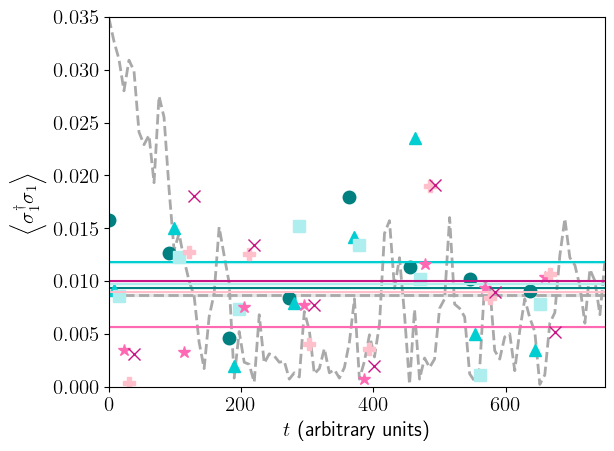

In [42]:
plt.rcParams.update({'font.size': 15})

plot_settings_ZNE = { 'linear' : ['teal', 'none', 'o', 'ZNE (linear)'], 
           'richardson' : { 'none' : ['darkturquoise', 'none', '^', 'ZNE (FOR)'], 
                             'l1' : ['paleturquoise', 'none', 's', 'ZNE (CFOR-l1)']} }

plot_settings_CDR = { 'inverse' : ['hotpink', 'none', '*', 'CDR (inverse)'],
               'gaussian' : ['pink', 'none', 'P', 'CDR (Gaussian)'],
               'uniform' : ['mediumvioletred', 'none', 'x', 'CDR (no bias)']}

error =  np.abs(raw_data - noiseless_data)
plt.plot(t,error , color = 'darkgrey', linestyle = 'dashed', linewidth = 2, label = 'Raw results (no amplification)')
plt.plot(t, np.ones(len(t))*np.mean(error), color = 'darkgrey', linestyle = 'dashed', linewidth = 2, label = 'Raw results (no amplification)')
upper_bound = np.ones(len(t))*np.mean(error) + np.ones(len(t))*np.var(error)
lower_bound = np.ones(len(t))*np.mean(error) - np.ones(len(t))*np.var(error)
plt.fill_between(t, lower_bound, upper_bound, color='darkgrey', alpha=0.2)

start = 0
end = -6
step = 12
for typ in zne_results['extrapolated_evs'].keys():
    if typ == 'richardson':
        for w_min in plot_settings_ZNE[typ].keys():
            error = np.abs(zne_results['extrapolated_evs'][typ][w_min] - noiseless_data)
            plt.plot(t[start:end:step], error[start:end:step], color = plot_settings_ZNE[typ][w_min][0], linestyle = plot_settings_ZNE[typ][w_min][1], marker = plot_settings_ZNE[typ][w_min][2], markersize = 9, label = plot_settings_ZNE[typ][w_min][3])

            plt.plot(t, np.ones(len(t))*np.mean(error), color = plot_settings_ZNE[typ][w_min][0], linestyle = 'solid')    
            upper_bound = np.ones(len(t))*np.mean(error) + np.ones(len(t))*np.var(error)
            lower_bound = np.ones(len(t))*np.mean(error) - np.ones(len(t))*np.var(error)
            plt.fill_between(t, lower_bound, upper_bound, color = plot_settings_ZNE[typ][w_min][0], alpha=0.2)       

            start += 1
            end += 1

    else:
        error = np.abs(zne_results['extrapolated_evs'][typ] - noiseless_data)
        plt.plot(t[start:end:step],  error[start:end:step], color = plot_settings_ZNE[typ][0], linestyle = plot_settings_ZNE[typ][1], marker = plot_settings_ZNE[typ][2], markersize = 9, label = plot_settings_ZNE[typ][3])
        
        plt.plot(t, np.ones(len(t))*np.mean(error), color = plot_settings_ZNE[typ][0], linestyle = 'solid')    
        upper_bound = np.ones(len(t))*np.mean(error) + np.ones(len(t))*np.var(error)
        lower_bound = np.ones(len(t))*np.mean(error) - np.ones(len(t))*np.var(error)
        plt.fill_between(t, lower_bound, upper_bound, color = plot_settings_ZNE[typ][0], alpha=0.2)

        start += 1
        end += 1
      
for typ in cdr_results.keys():
    error = np.abs(cdr_results[typ] - noiseless_data)
    plt.plot(t[start:end:step], error[start:end:step], color = plot_settings_CDR[typ][0], linestyle = plot_settings_CDR[typ][1], marker = plot_settings_CDR[typ][2], markersize = 9, label = plot_settings_CDR[typ][3])
    
    plt.plot(t, np.ones(len(t))*np.mean(error), color = plot_settings_CDR[typ][0], linestyle = 'solid')    
    upper_bound = np.ones(len(t))*np.mean(error) + np.ones(len(t))*np.var(error)
    lower_bound = np.ones(len(t))*np.mean(error) - np.ones(len(t))*np.var(error)
    plt.fill_between(t, lower_bound, upper_bound, color = plot_settings_CDR[typ][0], alpha=0.2)
    
    start += 1
    end += 1

plt.ylabel('$\\left< \\sigma^{\\dag}_1 \\sigma_1 \\right>$')
plt.xlim([0,750])
plt.ylim([0,0.035])
#plt.yticks([0, 0.1, 0.2])
#plt.xticks([0, 50, 100])
plt.xlabel('$t$ (arbitrary units)')
plt.savefig('fig4b', bbox_inches='tight')
plt.show()

## Scaling up to 10 emitters chain (15 total qubits)

For ten emitters, we have ZNE data and CDR (just for 20 data points for the moment and only using 'inverse' bias)